UN DATATHON

In [62]:
#Import libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
from functools import reduce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from scipy.stats.mstats import zscore
#from pyod.models.abod import ABOD
#from pyod.models.knn import KNN
import seaborn as sns
#from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas import Series
from matplotlib import pyplot

#import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import itertools
import math
import random



In [51]:
#Load all the data

# Set up the base directory for file paths
base_dir = Path(r'C:\Users\skhadijah\Downloads\datathon\project')

# Define a function to read a file safely
def safe_read_file(file_path, read_func):
    full_path = base_dir / file_path
    if not full_path.exists():
        print(f"File does not exist: {full_path}")
        return None
    try:
        return read_func(full_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Read each file into its own DataFrame
econ = safe_read_file('economic.xlsx', pd.read_excel) #year
exch = safe_read_file('exchangerates.csv', pd.read_csv) # year
exp = safe_read_file('export_clean.csv', pd.read_csv)
imp = safe_read_file('import_clean.csv', pd.read_csv)
gdp = safe_read_file('gdp_state.csv', pd.read_csv)
agriM = safe_read_file('MY-agri.xlsx', pd.read_excel)
sdg = safe_read_file('SDG.xlsx', pd.read_excel)
agriS = safe_read_file('State-agri.xlsx', pd.read_excel)
ppi = safe_read_file('ppi.csv', pd.read_csv)
cpi = safe_read_file('cpi_core.csv', pd.read_csv)


Data Processing

In [52]:

# Make sure to convert the 'date' column to datetime and extract the year
econ['Year'] = pd.to_datetime(econ['DATE']).dt.year
exch['Year'] = pd.to_datetime(exch['date']).dt.year
exp['Year'] = pd.to_datetime(exp['year'].astype(str) + '-' + exp['month']).dt.year
imp['Year'] = pd.to_datetime(imp['year'].astype(str) + '-' + imp['Row Labels']).dt.year
ppi['Year'] = pd.to_datetime(ppi['date']).dt.year
cpi['Year'] = pd.to_datetime(cpi['date']).dt.year

# Drop the 'date' column
econ = econ.drop('DATE', axis=1)
exch = exch.drop('date', axis=1)
exp = exp.drop(['month', 'year'], axis=1)
imp = imp.drop(['Row Labels', 'year'], axis=1)
ppi = ppi.drop('date', axis=1)
cpi = cpi.drop('date', axis=1)

# Attempt to convert all columns to numeric, coercing errors to NaN
econ_numeric = econ.apply(pd.to_numeric, errors='coerce')
exch_numeric = exch.apply(pd.to_numeric, errors='coerce')
exp_numeric = exp.apply(pd.to_numeric, errors='coerce')
imp_numeric = imp.apply(pd.to_numeric, errors='coerce')
ppi_numeric = ppi.apply(pd.to_numeric, errors='coerce')
cpi_numeric = cpi.apply(pd.to_numeric, errors='coerce')

# 'Year' will now be converted to NaN, so we need to restore it from 'exch'
econ_numeric['Year'] = exch['Year']
exch_numeric['Year'] = exch['Year']
exp_numeric['Year'] = exch['Year']
imp_numeric['Year'] = exch['Year']
ppi_numeric['Year'] = exch['Year']
cpi_numeric['Year'] = exch['Year']

# Select numeric columns excluding 'Year'
econ_numeric_cols = econ_numeric.select_dtypes(include=[np.number]).columns.difference(['Year'])
exch_numeric_cols = exch_numeric.select_dtypes(include=[np.number]).columns.difference(['Year'])
exp_numeric_cols = exp_numeric.select_dtypes(include=[np.number]).columns.difference(['Year'])
imp_numeric_cols = imp_numeric.select_dtypes(include=[np.number]).columns.difference(['Year'])
ppi_numeric_cols = ppi_numeric.select_dtypes(include=[np.number]).columns.difference(['Year'])
cpi_numeric_cols = cpi_numeric.select_dtypes(include=[np.number]).columns.difference(['Year'])

# Group by 'Year' and calculate the mean only for numeric columns
econ1 = econ_numeric.groupby('Year')[econ_numeric_cols].mean().reset_index()
exch1 = exch_numeric.groupby('Year')[exch_numeric_cols].mean().reset_index()
exp1 = exp_numeric.groupby('Year')[exp_numeric_cols].mean().reset_index()
imp1 = imp_numeric.groupby('Year')[imp_numeric_cols].mean().reset_index()
ppi1 = ppi_numeric.groupby('Year')[ppi_numeric_cols].mean().reset_index()
cpi1 = cpi_numeric.groupby('Year')[cpi_numeric_cols].mean().reset_index()

# Filter the SDG data for only Malaysia
sdg1 = sdg[sdg['Country'] == 'Malaysia'].reset_index(drop=True)

# Ensure that 'Year' is an integer for consistent merging
data_frames = [df.astype({'Year': 'int32'}) for df in [econ1, exch1, exp1, imp1, ppi1, cpi1, sdg1, agriM]]

# Use reduce to merge all dataframes on 'Year'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Year', how='outer'), data_frames)

# Sort the dataframe by 'Year'
merged_df = merged_df.sort_values(by='Year')

# Save the combined DataFrame to a CSV file
merged_df.to_csv(f'{base_dir}/combined_data.csv', index=False)

merged_df.head()

C:\Users\skhadijah\AppData\Local\Temp\1\ipykernel_15104\1464006792.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  exp['Year'] = pd.to_datetime(exp['year'].astype(str) + '-' + exp['month']).dt.year
C:\Users\skhadijah\AppData\Local\Temp\1\ipykernel_15104\1464006792.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imp['Year'] = pd.to_datetime(imp['year'].astype(str) + '-' + imp['Row Labels']).dt.year


,Year,ACTIVEJOBS,ALRCB,CIC,CONSCRE,CPI,CRUDEBRUSD,EXSITC0,EXSITC1,EXSITC2,...,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215
21,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2003,77259.20000,6.280910,82.819355,16.603908,89.954839,63.076129,955.229205,155.986193,1290.710595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004,281003.62069,4.736206,100.770833,5.468431,112.477882,73.767813,2317.255739,281.979900,1908.714130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Imputation - Missing Value

In [53]:

# Assuming 'merged_df' is the DataFrame you are working with
df = merged_df.copy()

# Remove the 'Year' column to prevent it from being imputed
if 'Year' in df.columns:
    year_data = df.pop('Year')

# Identify numeric columns for imputation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Initialize the MICE imputer
mice_imputer = IterativeImputer()

# Confirm the number of numeric columns before imputation
print("Number of numeric columns before imputation:", len(numeric_cols))

# Perform MICE imputation on the numeric data
imputed_data = mice_imputer.fit_transform(df[numeric_cols])

# Confirm the shape of the imputed data
print("Shape of imputed data:", imputed_data.shape)

# If the shape of the imputed data matches the number of numeric columns, proceed to create a new DataFrame
if imputed_data.shape[1] == len(numeric_cols):
    # Create a DataFrame with the imputed data
    imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols)
    
    # Add the 'Year' column back to the DataFrame
    imputed_df['Year'] = year_data.values
    imputed_df = imputed_df[['Year'] + [col for col in imputed_df.columns if col != 'Year']]
    
    # Reset the index of the DataFrame
    imputed_df.reset_index(drop=True, inplace=True)
    
    # Display the first few rows to verify
    print(imputed_df.head())
else:
    print("Mismatch in the number of columns after imputation.")


Number of numeric columns before imputation: 448


C:\Users\skhadijah\AppData\Roaming\Python\Python38\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: [111 119 135 136 137 142 144 150 169 170 178 180 184 185 189 198 202 217
 219 227]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Shape of imputed data: (24, 428)
Mismatch in the number of columns after imputation.


In [55]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np

# Assuming 'merged_df' is the DataFrame you are working with
df = merged_df.copy()

# Remove the 'Year' column to prevent it from being imputed
if 'Year' in df.columns:
    year_data = df.pop('Year')

# Identify columns that only contain missing values
columns_with_only_missing_values = df.columns[df.isnull().all()].tolist()

# Report these columns
print("Columns with only missing values:", columns_with_only_missing_values)

# Drop these columns from the dataset
df.drop(columns=columns_with_only_missing_values, inplace=True)

# Now perform imputation on the dataset without the completely missing columns
# Identify numeric columns for imputation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Initialize the MICE imputer
mice_imputer = IterativeImputer()

# Perform MICE imputation on the numeric data
imputed_data = mice_imputer.fit_transform(df[numeric_cols])

# The imputed data should now match the number of numeric columns we have after dropping completely missing ones
imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols)

# Add the 'Year' column back to the DataFrame
imputed_df['Year'] = year_data.values

# Sort the DataFrame by 'Year' after imputation
imputed_df = imputed_df[['Year'] + [col for col in imputed_df.columns if col != 'Year']]
imputed_df.sort_values('Year', inplace=True)

# Reset the index of the DataFrame
imputed_df.reset_index(drop=True, inplace=True)

# Display the first few rows to verify
print(imputed_df.head())

# Save the combined DataFrame to a CSV file
imputed_df.to_csv(f'{base_dir}/impute_data.csv', index=False)

imputed_df.head()

Columns with only missing values: ['sdg1_oecdpov', 'sdg2_yieldgap', 'sdg3_region', 'sdg3_incomeg', 'sdg3_smoke', 'sdg4_tertiary', 'sdg4_socioec', 'sdg5_paygap', 'sdg8_empop', 'sdg8_yneet', 'sdg9_rdres', 'sdg9_netacc', 'sdg10_elder', 'sdg11_slums', 'sdg11_rentover', 'sdg12_mswrecycl', 'sdg13_ecr', 'sdg16_u5reg', 'sdg16_clabor', 'sdg17_oda']
   Year     ACTIVEJOBS     ALRCB         CIC    CONSCRE         CPI  \
0  2000  179131.410345  5.508558   91.795094  11.036169  101.216360   
1  2001  179131.410345  5.508558   91.795094  11.036169  101.216360   
2  2002  179131.410345  5.508558   91.795094  11.036169  101.216360   
3  2003   77259.200000  6.280910   82.819355  16.603908   89.954839   
4  2004  281003.620690  4.736206  100.770833   5.468431  112.477882   

   CRUDEBRUSD      EXSITC0     EXSITC1      EXSITC2  ...        X206  \
0   68.421971  1636.242472  218.983046  1599.712363  ...  127.367334   
1   68.421971  1636.242472  218.983046  1599.712363  ...  127.372692   
2   68.421971  

,Year,ACTIVEJOBS,ALRCB,CIC,CONSCRE,CPI,CRUDEBRUSD,EXSITC0,EXSITC1,EXSITC2,...,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215
0,2000,179131.410345,5.508558,91.795094,11.036169,101.216360,68.421971,1636.242472,218.983046,1599.712363,...,127.367334,128.749404,125.370398,127.959957,109.550866,942794.900309,789800.475547,156546.285366,105599.746676,71433.610798
1,2001,179131.410345,5.508558,91.795094,11.036169,101.216360,68.421971,1636.242472,218.983046,1599.712363,...,127.372692,128.755485,125.374723,127.965721,109.551979,942817.910534,789828.451962,156555.439092,105590.997926,71419.053095
2,2002,179131.410345,5.508558,91.795094,11.036169,101.216360,68.421971,1636.242472,218.983046,1599.712363,...,127.372692,128.755485,125.374723,127.965721,109.551979,942817.910277,789828.452927,156555.437975,105590.997941,71419.052428
3,2003,77259.200000,6.280910,82.819355,16.603908,89.954839,63.076129,955.229205,155.986193,1290.710595,...,127.372916,128.755416,125.374830,127.965613,109.552041,942817.932790,789826.452408,156557.104261,105591.348509,71421.744067
4,2004,281003.620690,4.736206,100.770833,5.468431,112.477882,73.767813,2317.255739,281.979900,1908.714130,...,127.372945,128.755461,125.374857,127.965659,109.552046,942817.633529,789825.859703,156557.072925,105591.261553,71421.435376


Data Exploration

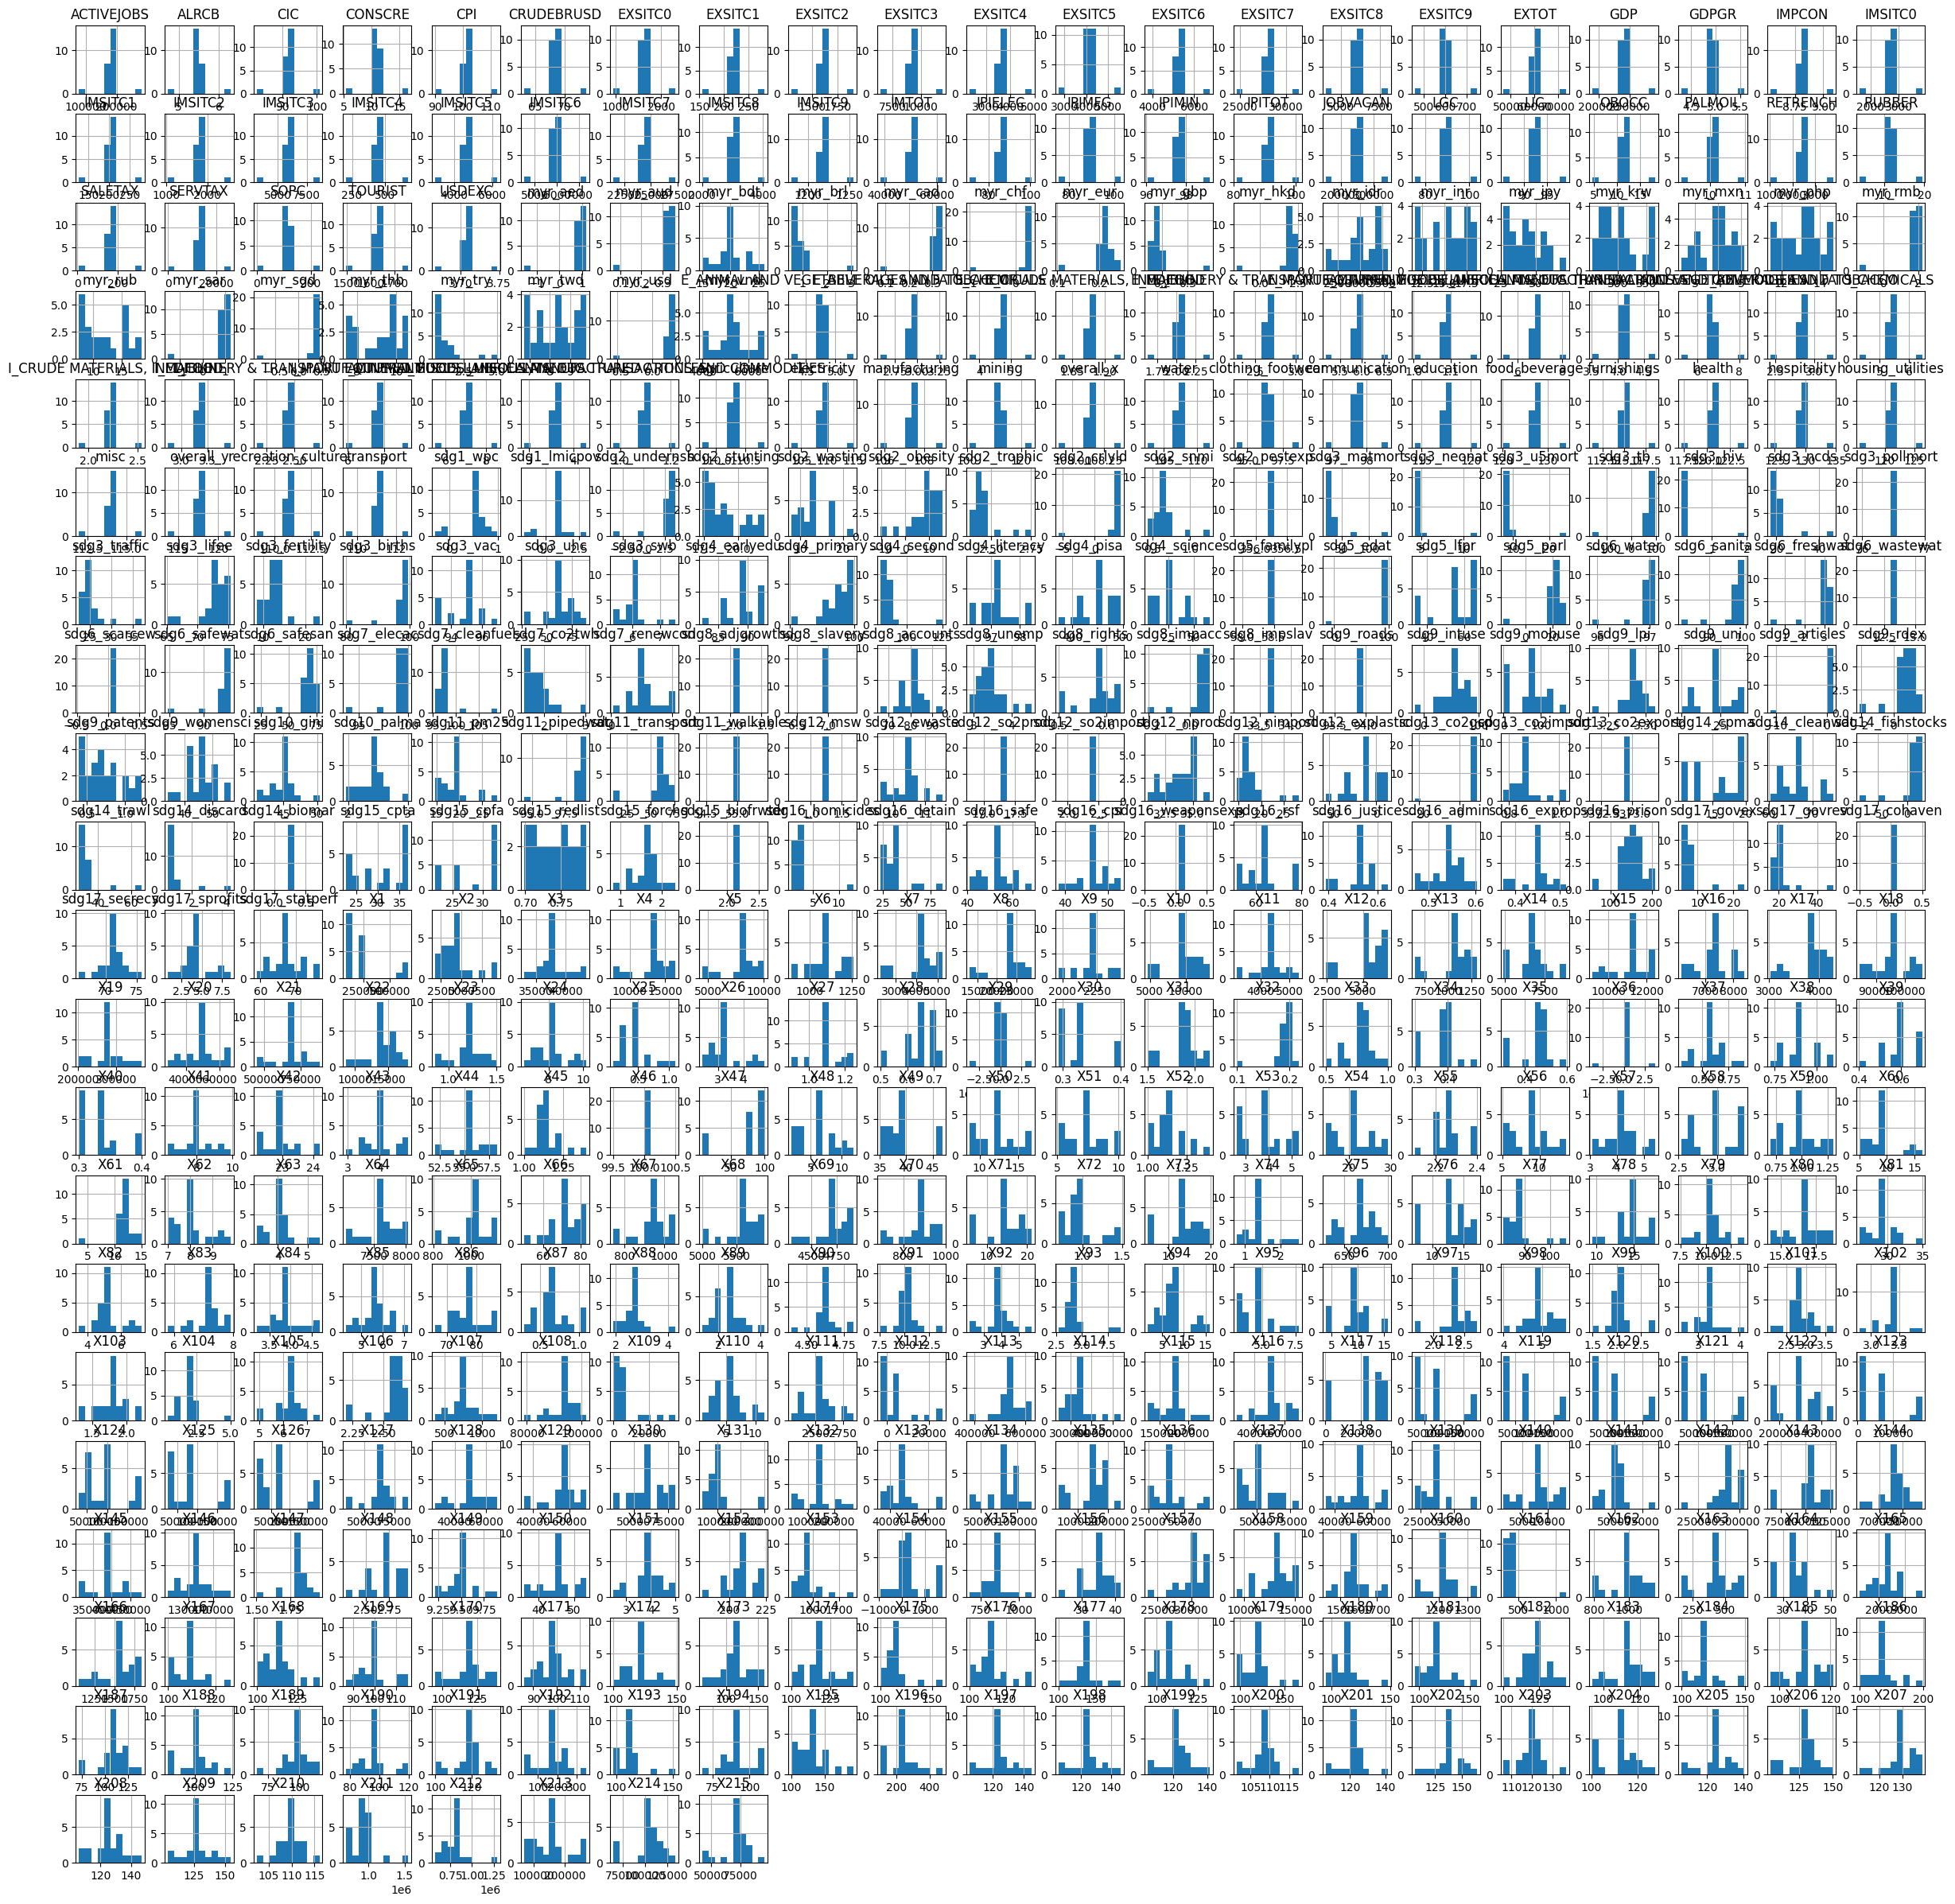

In [59]:
#Copy imputed_df
fs = imputed_df.copy()

# Histogram of all numeric fields
df_hist = fs.drop(columns=['Year'],axis=1)
df_hist.hist(figsize=(30,30));

In [60]:
# Understanding the numeric fields
quality=fs.describe()
quality

,Year,ACTIVEJOBS,ALRCB,CIC,CONSCRE,CPI,CRUDEBRUSD,EXSITC0,EXSITC1,EXSITC2,...,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,2.400000e+01,24.000000,24.000000,24.000000
mean,2011.500000,179131.410345,5.508558,91.795094,11.036169,101.216360,68.421971,1636.242472,218.983046,1599.712363,...,127.372692,128.755485,125.374723,127.965720,109.551979,9.428179e+05,7.898284e+05,156555.453661,105590.997035,71419.058051
std,7.071068,30040.475942,0.227754,2.646801,1.641837,3.320842,1.576403,200.819857,18.576759,91.119650,...,11.118000,6.384118,9.056296,11.034520,2.759197,1.774456e+05,1.383773e+05,56207.971634,16596.463859,12111.003387
min,2000.000000,77259.200000,4.736206,82.819355,5.468431,89.954839,63.076129,955.229205,155.986193,1290.710595,...,104.100000,111.500000,106.000000,104.600000,102.400000,6.978620e+05,5.736260e+05,71298.000000,64862.000000,42928.000000
25%,2005.750000,179131.410344,5.508558,91.795094,11.036169,101.216360,68.421971,1636.242472,218.983046,1599.712363,...,127.119136,127.694663,123.844055,125.118013,108.119103,8.979362e+05,7.355547e+05,117463.500000,105590.997937,71419.052929
50%,2011.500000,179131.410345,5.508558,91.795094,11.036169,101.216360,68.421971,1636.242472,218.983046,1599.712363,...,127.372930,128.755485,125.374833,127.965691,109.552013,9.428179e+05,7.898265e+05,156555.469391,105872.373338,71641.095880
75%,2017.250000,179131.410345,5.508558,91.795094,11.036169,101.216360,68.421971,1636.242472,218.983046,1599.712363,...,132.841354,134.175000,131.025000,131.691211,111.125000,9.835539e+05,8.012720e+05,178690.426322,113098.583843,77590.500000
max,2023.000000,281003.620690,6.280910,100.770833,16.603908,112.477882,73.767813,2317.255739,281.979900,1908.714130,...,150.200000,138.400000,146.600000,154.100000,116.100000,1.550009e+06,1.293811e+06,267673.426685,133872.000000,95222.000000


Feature Selection

Target variable for food security in Malaysia could be:

CPI Food: The Consumer Price Index (CPI) for food, which reflects the cost of a basket of food items and is directly related to food affordability and accessibility, key aspects of food security.
eg. CPI Food (X198), CPI Food&Beverages

Direct measures of food security (such as the prevalence of undernourishment, food supply adequacy, etc.), those could serve as even more precise target variables.
sdg2_undernsh: Prevalence of undernourishment (%). This directly measures the portion of the population that is not getting enough food and is a clear indicator of food insecurity.
sdg2_stunting: Prevalence of stunting in children under 5 years of age (%). Chronic food insecurity leads to stunting in children, making this a key indicator.
sdg2_wasting: Prevalence of wasting in children under 5 years of age (%). This indicates acute food insecurity, reflecting recent and severe undernutrition.
sdg2_crlyld: Cereal yield (tonnes per hectare of harvested land). While this is more of an indicator of agricultural productivity, it's closely related to the capacity of a country to meet its food needs.
sdg2_yieldgap: Yield gap closure (% of potential yield). This shows the difference between actual and potential yields, indicating how well a country is utilizing its agricultural capacity to secure food.



In [63]:
#Copy imputed_df
fs = imputed_df.copy()

# Define the target variable Y
Target = imputed_df['sdg2_undernsh']

# Define the independent variables X, excluding 'sdg2_undernsh' and 'Year'
predictors = imputed_df.drop(columns=['sdg2_undernsh', 'Year'])

C:\Users\skhadijah\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\skhadijah\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\skhadijah\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 427 features.
Fitting estimator with 417 features.
Fitting estimator with 407 features.
Fitting estimator with 397 features.
Fitting estimator with 387 features.
Fitting estimator with 377 features.
Fitting estimator with 367 features.
Fitting estimator with 357 features.
Fitting estimator with 347 features.
Fitting estimator with 337 features.
Fitting estimator with 327 features.
Fitting estimator with 317 features.
Fitting estimator with 307 features.
Fitting estimator with 297 features.
Fitting estimator with 287 features.
Fitting estimator with 277 features.
Fitting estimator with 267 features.
Fitting estimator with 257 features.
Fitting estimator with 247 features.
Fitting estimator with 237 features.
Fitting estimator with 227 features.
Fitting estimator with 217 features.
Fitting estimator with 207 features.
Fitting estimator with 197 features.
Fitting estimator with 187 features.
Fitting estimator with 177 features.
Fitting estimator with 167 features.
F

,feature,number_of_models
2,sdg2_obesity,5
6,sdg7_co2twh,5
9,sdg17_govex,5
22,sdg3_matmort,4
3,sdg2_trophic,4
...,...,...
43,sdg16_admin,2
44,sdg16_justice,2
8,sdg15_redlist,2
146,myr_jpy,2


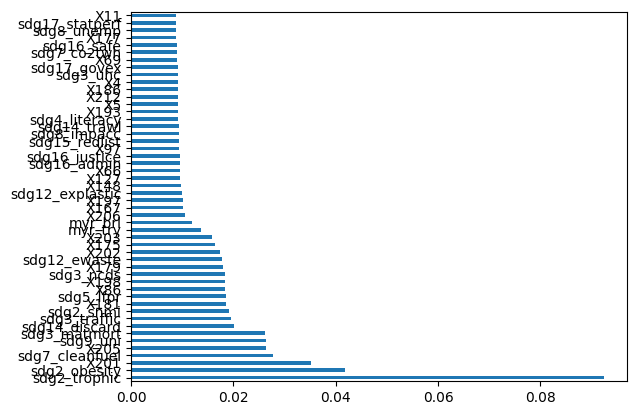

In [123]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(10)

#1.Select the top n features based on feature importance from random forest

# define the model
model = RandomForestRegressor(random_state = random.seed(10))
# fit the model
model.fit(predictors, Target)

# get importance
features = predictors
importances = model.feature_importances_
indices = np.argsort(importances)

feat_importances = pd.Series(model.feature_importances_, index=predictors.columns)
feat_importances.nlargest(50).plot(kind='barh')

#Final Features from Random Forest (Select Features with highest feature importance)
rf_top_features = pd.DataFrame(feat_importances.nlargest(47)).axes[0].tolist()

#2.Select the top n features based on absolute correlation with target variable
# Assuming 'Target' is a NumPy array and 'predictors' is a DataFrame
corr_data1 = pd.concat([pd.Series(Target.flatten(), name='Target'), predictors], axis=1)
corr_data = corr_data1.corr()
corr_data = corr_data.iloc[: , [0]]
corr_data.columns.values[0] = "Correlation"
corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()]
corr_data = corr_data[corr_data['Correlation'].notna()]
corr_data = corr_data.loc[corr_data['Correlation'] != 1]

# Select Features with greater than 50% absolute correlation
corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > 0.5]
#corr_top_features = corr_data2.axes[0].tolist()

#3.Select the features identified by Lasso regression

# Create a pipeline with a scaler and LassoCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(cv=5, max_iter=10000))
])

# Fit the pipeline on your data
pipeline.fit(predictors, Target)

# Create SelectFromModel object with the LassoCV estimator
sfm = SelectFromModel(pipeline.named_steps['lasso_cv'], threshold='mean')

# Fit SelectFromModel
sfm.fit(pipeline.named_steps['scaler'].transform(predictors), Target)

# Get the support mask of the selected features
selected_features = sfm.get_support()

# Apply the transformation to the dataset
predictors_selected = sfm.transform(pipeline.named_steps['scaler'].transform(predictors))

# Get the feature names
feature_names = np.array(predictors.columns)
lasso_feature_names = feature_names[selected_features]

#4.Perform recursive feature selection and use cross validation to identify the best number of features

#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select= 47, step=10, verbose=5)
rfe_selector.fit(predictors, Target)
rfe_support = rfe_selector.get_support()
rfe_feature = predictors.loc[:,rfe_support].columns.tolist()

#5.Select the top n features based on absolute value of beta coefficients of features

# Define the standard scaler
scaler = StandardScaler()

# Transform predictors
scaled_predictors = scaler.fit_transform(predictors)

# Reshape Target to be a 2D array if it's a pandas Series or a 1D numpy array
if isinstance(Target, pd.Series) or len(Target.shape) == 1:
    Target = Target.values.reshape(-1, 1)

# Transform target
scaled_Target = scaler.fit_transform(Target)

# Fit the regression model
sr_reg = LinearRegression(fit_intercept=False).fit(scaled_predictors, scaled_Target.ravel())  # Use ravel() to convert back to 1D array for the fit method

# Create a dataframe for coefficients
coef_table = pd.DataFrame(list(predictors.columns)).copy()
coef_table.insert(len(coef_table.columns), "Coefs", sr_reg.coef_.transpose())

# Sort by absolute values of coefficients in descending order
coef_table = coef_table.reindex(coef_table.Coefs.abs().argsort()[::-1])

# Select top n features
n_top_features = 55
sr_top_features = coef_table.head(n_top_features).iloc[:, 0].tolist()

# Combine the selected features into a single list
all_selected_features = (
    list(lasso_feature_names) +
    list(rf_top_features) +
    list(corr_top_features) +
    list(rfe_feature) +
    list(sr_top_features)
)

# Count the occurrences of each feature
feature_counts = Counter(all_selected_features)

# Convert the counter to a DataFrame
combined_feature_data = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['number_of_models']).reset_index()

# Rename the columns appropriately
combined_feature_data.rename(columns={'index': 'feature'}, inplace=True)

# Sort the features by the number of models that selected them
combined_feature_data.sort_values(by='number_of_models', ascending=False, inplace=True)

# Optionally, you can filter out features that were not selected by a minimum number of models
min_models = 2  # For example, you want the feature to be selected by at least 3 models
filtered_features = combined_feature_data[combined_feature_data['number_of_models'] >= min_models]

# Save the combined DataFrame to a CSV file
filtered_features.to_csv(f'{base_dir}/features_data.csv', index=False)

# Display the combined feature data
filtered_features


Stationarity and Transformation

In [124]:
# Get the list of selected features
selected_features_list = filtered_features['feature'].tolist()

# Create a new DataFrame with only selected features
selected_predictors = predictors[selected_features_list]

# Now, 'selected_predictors' can be used for further modeling
selected_predictors.head()

,sdg2_obesity,sdg7_co2twh,sdg17_govex,sdg3_matmort,sdg2_trophic,sdg14_trawl,sdg14_discard,myr_try,sdg7_cleanfuel,sdg3_traffic,...,sdg9_uni,X32,sdg9_intuse,sdg7_renewcon,myr_rub,sdg16_admin,sdg16_justice,sdg15_redlist,myr_jpy,sdg16_prison
0,7.0,1.776,7.142,39.75,2.456,33.694,1.120,1.300414,98.0,26.83,...,22.840379,0.191564,21.385,3.2,11.736681,0.540489,0.520788,0.786,29.358090,151.145602
1,7.5,1.893,8.834,35.71,2.450,33.365,1.064,1.102989,98.0,25.43,...,22.844396,0.191583,26.696,3.2,11.956699,0.540479,0.520810,0.782,28.720646,151.124027
2,7.9,1.799,9.028,36.47,2.456,34.550,0.977,1.102992,98.1,25.09,...,22.844395,0.191583,32.338,2.6,11.956709,0.540479,0.520810,0.778,28.720638,151.124027
3,8.4,1.968,9.023,32.07,2.445,34.062,0.898,0.353535,98.2,26.24,...,22.844330,0.191585,34.971,2.4,7.744783,0.540482,0.520813,0.773,28.362417,129.854591
4,8.9,2.100,7.384,32.55,2.438,33.550,0.757,0.353535,98.1,25.49,...,22.844342,0.191585,42.252,2.4,7.581017,0.540482,0.520813,0.771,28.462495,172.381000


In [125]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller test
def adfuller_test(series, signif=0.05):
    r = adfuller(series.dropna(), autolag='AIC')  # dropna() to remove any NaNs that could interfere with the test
    p_value = r[1]
    if p_value <= signif:
        return True  # Stationary
    else:
        return False  # Non-Stationary

# Function to apply transformation based on ADF test
def apply_transformation(series, max_diff=2):
    if adfuller_test(series):
        return series  # Return original if stationary
    for i in range(1, max_diff+1):
        # Apply differencing
        transformed = series.diff(i).dropna()  # Drop NaNs after differencing
        if adfuller_test(transformed):
            return transformed
    # If still not stationary, apply log transformation and then differencing
    transformed = np.log(series)
    for i in range(1, max_diff+1):
        transformed_diff = transformed.diff(i).dropna()
        if adfuller_test(transformed_diff):
            return transformed_diff
    return transformed  # Return log transformed if no differencing made it stationary

# Create a new DataFrame for transformed predictors
transformed_predictors = pd.DataFrame()

# Apply ADF test and transformation
for column in selected_predictors.columns:
    transformed_series = apply_transformation(selected_predictors[column])
    transformed_predictors[column] = transformed_series

# Drop rows with NaNs resulting from transformations
transformed_predictors.dropna(inplace=True)

# Now you can use 'transformed_predictors' for further modeling
transformed_predictors.head()

C:\Users\skhadijah\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\skhadijah\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\skhadijah\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\skhadijah\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,sdg2_obesity,sdg7_co2twh,sdg17_govex,sdg3_matmort,sdg2_trophic,sdg14_trawl,sdg14_discard,myr_try,sdg7_cleanfuel,sdg3_traffic,...,sdg9_uni,X32,sdg9_intuse,sdg7_renewcon,myr_rub,sdg16_admin,sdg16_justice,sdg15_redlist,myr_jpy,sdg16_prison
2,0.4,-0.094,0.194,36.47,0.000,1.185,-0.085304,-0.164656,0.1,25.09,...,22.844395,0.191583,0.191729,-0.6,0.220027,-6.659739e-11,0.520810,-0.004,28.720638,3.239177e-07
3,0.5,0.169,-0.005,32.07,-0.005,-0.488,-0.084317,-1.137796,0.1,26.24,...,22.844330,0.191585,0.078276,-0.2,-4.211916,2.448348e-06,0.520813,-0.005,28.362417,-2.126944e+01
4,0.5,0.132,-1.639,32.55,-0.018,-0.512,-0.170807,-1.137798,-0.1,25.49,...,22.844342,0.191585,0.189133,0.0,-4.375691,2.053979e-07,0.520813,-0.002,28.462495,4.252641e+01
5,0.5,0.016,-0.100,32.15,-0.014,-2.799,-0.177314,0.003868,0.0,24.88,...,22.844366,0.191584,0.140568,-0.1,-0.268639,-5.778298e-07,0.520813,-0.005,29.099561,-3.363800e+01
6,0.5,-0.181,-1.128,32.00,-0.002,-1.105,0.046233,0.101367,0.0,24.74,...,22.844356,0.191584,0.060038,0.2,-0.115019,-6.085743e-08,0.520812,-0.003,31.787598,2.303500e+01


Time Series - Random Forest

In [126]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare the data
X = selected_predictors.values
y = imputed_df['sdg2_undernsh'].values

# Since it's a time series, the train-test split should be done in a way to preserve the time order
split_ratio = 0.8  
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Initialize and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tune these hyperparameters
rf_model.fit(X_train, y_train)

# Predict the test set to evaluate the model
y_pred = rf_model.predict(X_test)

# For the next 5 years forecast, we will recursively use the predictions as part of the input
last_features = selected_predictors.iloc[-1].values.reshape(1, -1)
forecast = []

for _ in range(5):  # Predict the next 5 years
    next_year_pred = rf_model.predict(last_features)[0]  # Predict the next step
    forecast.append(next_year_pred)
    
    # Update the'last_features' with 'next_year_pred' here before the next iteration
    # This part is very specific to how the features are constructed

# The 'forecast' list now contains the forecasts for the next 5 years
print("Forecast for the next 5 years:", forecast)


Forecast for the next 5 years: [2.88559187046676, 2.88559187046676, 2.88559187046676, 2.88559187046676, 2.88559187046676]


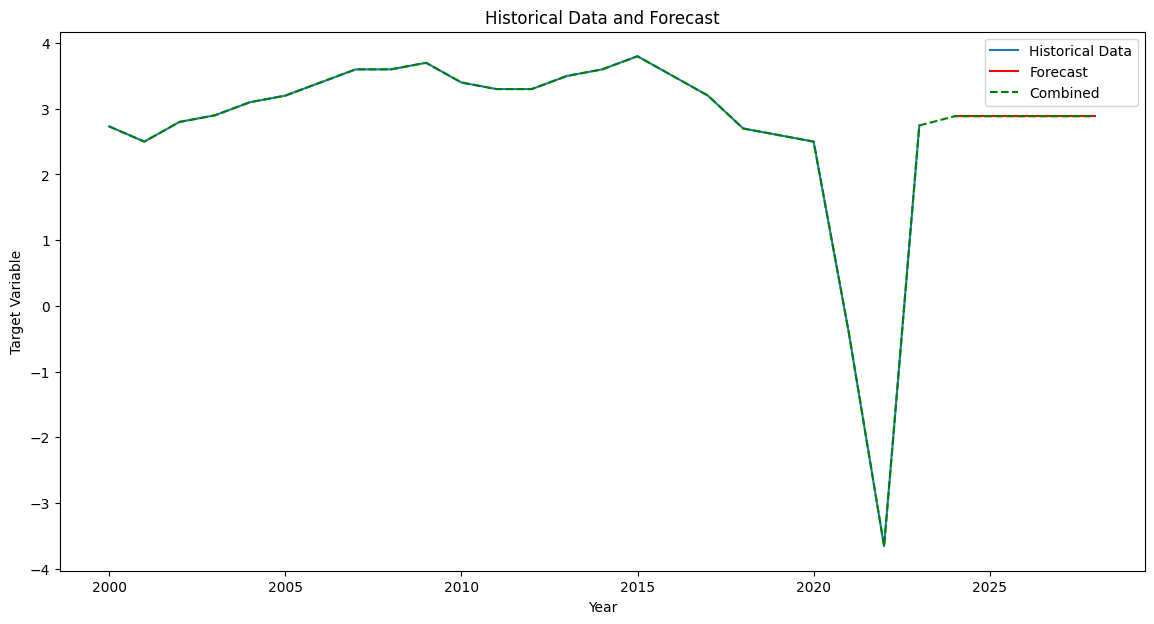

In [127]:
import matplotlib.pyplot as plt

# Plot the historical data
plt.figure(figsize=(14, 7))
years = imputed_df['Year']  # Assuming the 'Year' column exists and is in the correct order
plt.plot(years, y, label='Historical Data')

# Plot the forecasted data
# Create a list for the next 5 years assuming the last year in your dataset is 2023
forecast_years = list(range(years.iloc[-1] + 1, years.iloc[-1] + 6))
plt.plot(forecast_years, forecast, label='Forecast', color='red')

# Combine historical and forecasted data for a continuous line
combined_years = list(years) + forecast_years
combined_values = list(y) + forecast

plt.plot(combined_years, combined_values, label='Combined', color='green', linestyle='--')

plt.title('Historical Data and Forecast')
plt.xlabel('Year')
plt.ylabel('Target Variable')
plt.legend()
plt.show()
